2025-11-25 13:04:08.756478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764075848.928483      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764075848.978197      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

                   高难度迷宫游戏 DQN vs Double DQN 对比实验

游戏规则说明：
1. 环境：15x15的复杂迷宫，包含多种陷阱和局部最优路径
2. 目标：智能体从起点(绿色)移动到终点(红色)，避开墙壁(黑色)和陷阱(紫色)
3. 动作：上、下、左、右四个方向移动
4. 奖励：到达终点+50分，每步有距离惩罚，陷阱区域有高额惩罚
5. 难点：迷宫包含多个局部最优解和误导性路径，考验算法稳定性
6. 对比：DQN容易因Q值过估计陷入局部最优，Double DQN能更好找到全局最优
GPU可用: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow版本: 2.18.0
使用GPU进行加速训练
高难度环境: DQN vs Double DQN - Q值过估计对比实验

高难度迷宫环境展示

高难度迷宫信息:
尺寸: 15x15
起点位置: (1, 1)
终点位置: (13, 13)
墙壁数量: 75
陷阱数量: 12
最短理论路径长度: 24


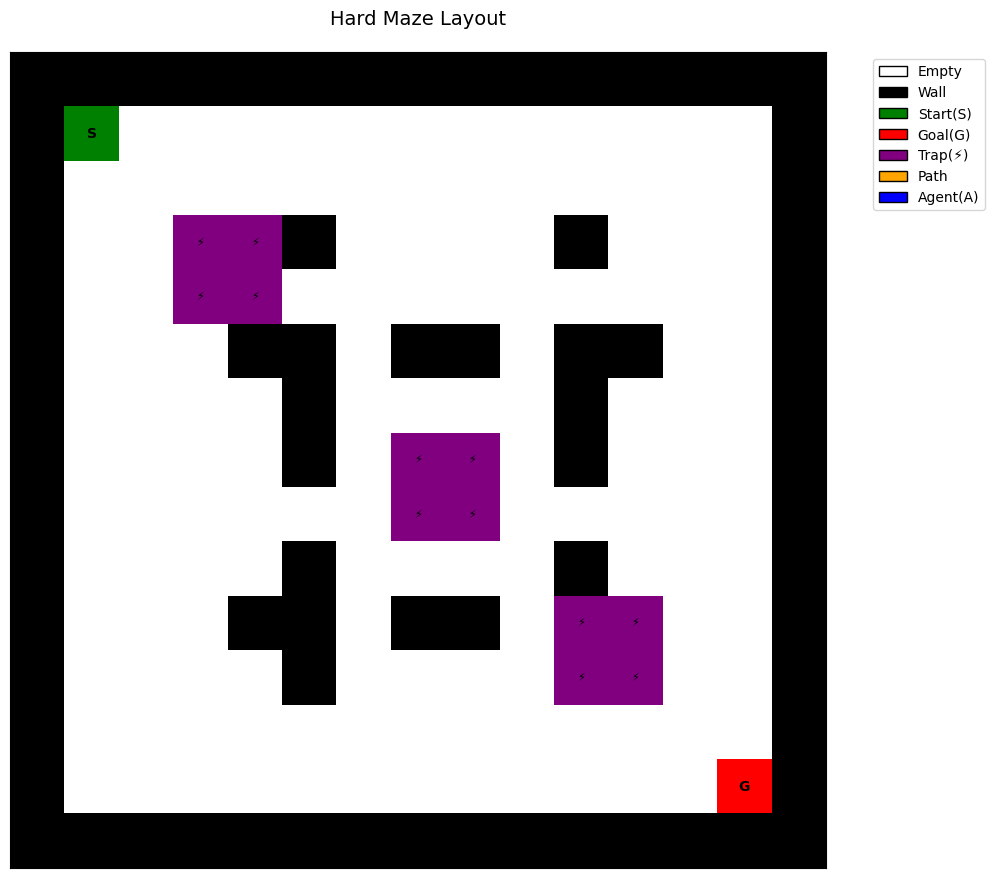

I0000 00:00:1764075864.377714      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



开始高难度环境下的DQN vs Double DQN对比训练...
迷宫尺寸: 15x15
训练回合数: 100


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1764075866.432841     108 service.cc:148] XLA service 0x7ca1bc005280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764075866.433508     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764075866.455464     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764075866.528818     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Training Progress: 100%|██████████| 100/100 [08:42<00:00,  5.23s/it]



总训练时间: 523.33 秒
平均每回合时间: 5.23 秒

绘制对比结果...


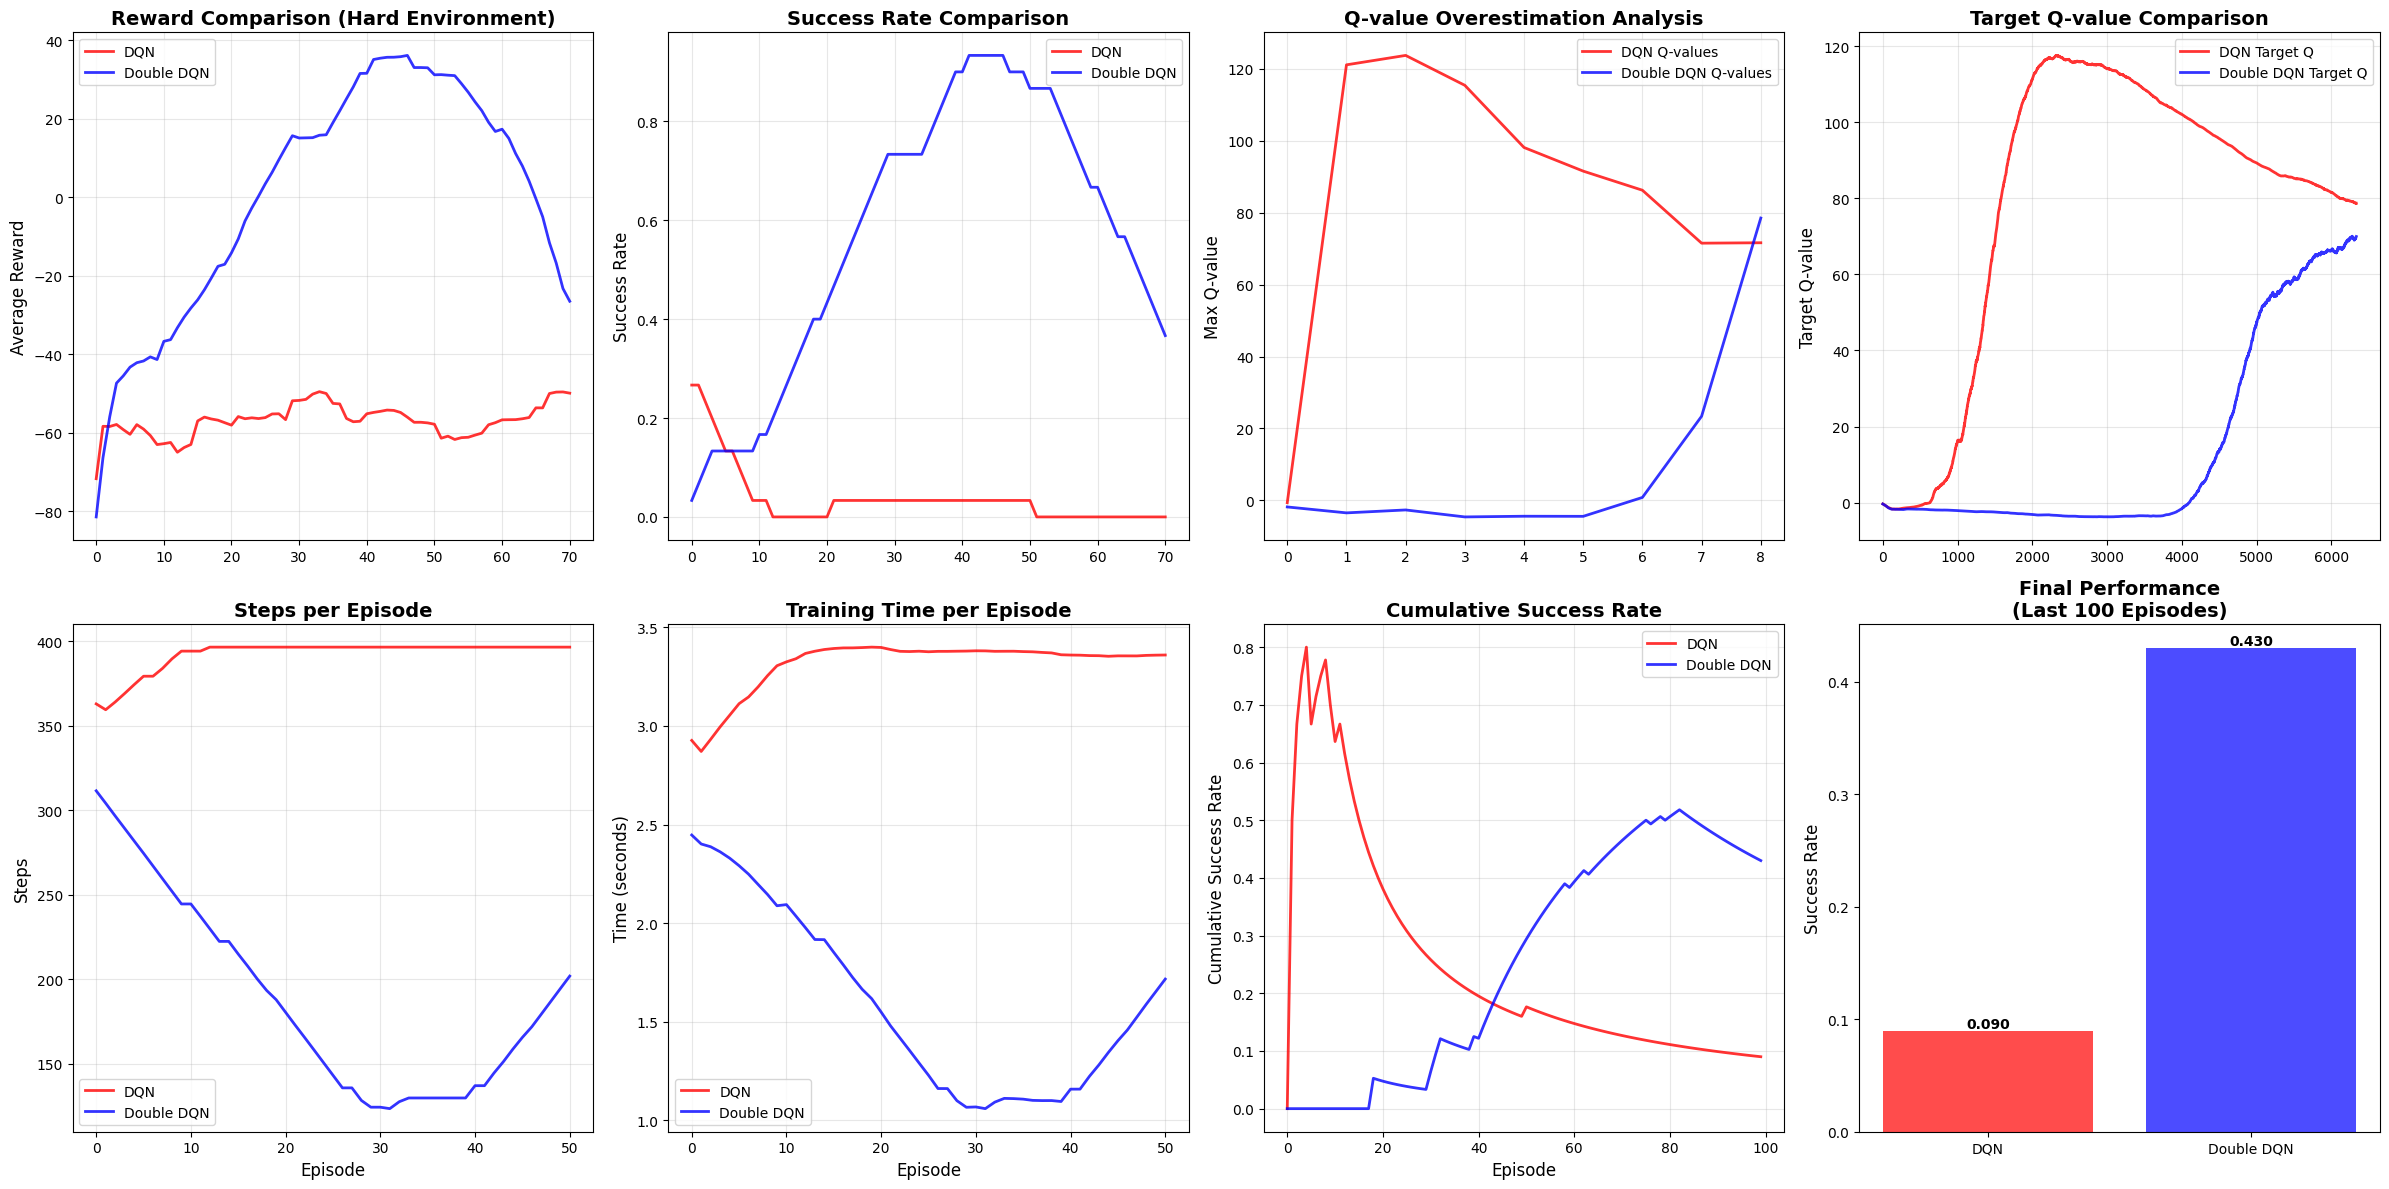


Q值过估计分析 (高难度环境)
平均最大Q值(最后50次记录):
  DQN: 86.5154
  Double DQN: 9.0367
  过估计减少: 89.6%

高难度环境下的理论解释:
1. 复杂环境加剧了DQN的过估计问题，导致更容易陷入局部最优
2. Double DQN通过动作选择与评估的解耦，在复杂环境中表现更稳定
3. 陷阱和局部最优路径使得准确的Q值估计更加重要

最终性能总结 (高难度环境)
最后100回合性能:
DQN - 成功率: 0.090
Double DQN - 成功率: 0.430
性能提升: 377.8%

最终迷宫状态和路径分析:

测试智能体路径 (3 次测试):
  测试 1: 未到达终点，步数: 300
  测试 2: 未到达终点，步数: 300
  测试 3: 未到达终点，步数: 300

测试智能体路径 (3 次测试):
  测试 1: 未到达终点，步数: 300
  测试 2: 未到达终点，步数: 300
  测试 3: 未到达终点，步数: 300

高难度环境对比实验完成!


In [1]:
# Double DQN vs DQN对比实验 - 高难度迷宫游戏实现（Kaggle GPU加速版本）
import numpy as np
import tensorflow as tf
import random
from collections import deque
import matplotlib.pyplot as plt
from matplotlib import colors
import time
import os
from tqdm import tqdm

# 设置环境变量优化TensorFlow性能
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

print("=" * 80)
print("                   高难度迷宫游戏 DQN vs Double DQN 对比实验")
print("=" * 80)
print("\n游戏规则说明：")
print("1. 环境：15x15的复杂迷宫，包含多种陷阱和局部最优路径")
print("2. 目标：智能体从起点(绿色)移动到终点(红色)，避开墙壁(黑色)和陷阱(紫色)")
print("3. 动作：上、下、左、右四个方向移动")
print("4. 奖励：到达终点+50分，每步有距离惩罚，陷阱区域有高额惩罚")
print("5. 难点：迷宫包含多个局部最优解和误导性路径，考验算法稳定性")
print("6. 对比：DQN容易因Q值过估计陷入局部最优，Double DQN能更好找到全局最优")
print("=" * 80)

# 检查GPU是否可用
print("GPU可用:", tf.config.list_physical_devices('GPU'))
print("TensorFlow版本:", tf.__version__)

# 设置随机种子
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 优化GPU配置
if tf.config.list_physical_devices('GPU'):
    print("使用GPU进行加速训练")
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.optimizer.set_jit(True)
        except RuntimeError as e:
            print(e)
else:
    print("使用CPU进行训练")

# 定义高难度迷宫环境类
class HardMazeEnv:
    """高难度迷宫环境"""
    
    def __init__(self, size=15):
        self.size = size
        self.actions = ['上', '右', '下', '左']
        self.action_space = 4
        self.observation_space = size * size
        
        self.move_increments = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.maze = None
        self.agent_pos = None
        self.start_pos = None
        self.goal_pos = None
        self._create_hard_maze()
        self.reset()
    
    def _create_hard_maze(self):
        """创建高难度迷宫，包含多个局部最优路径和陷阱"""
        self.maze = np.zeros((self.size, self.size), dtype=np.int8)
        
        # 设置边界
        self.maze[0, :] = 1
        self.maze[-1, :] = 1
        self.maze[:, 0] = 1
        self.maze[:, -1] = 1
        
        # 创建复杂的迷宫结构 - 增加难度
        # 1. 主障碍墙
        for i in range(3, self.size-3):
            if i % 4 != 0:  # 创建不规则的障碍模式
                self.maze[i, 5] = 1
                self.maze[i, 10] = 1
        
        # 2. 横向障碍
        for j in range(3, self.size-3):
            if j % 3 != 0:
                self.maze[5, j] = 1
                self.maze[10, j] = 1
        
        # 3. 创建死胡同和局部最优区域
        # 左上角局部最优区域
        for i in range(1, 4):
            for j in range(1, 4):
                if (i, j) != (1, 1):
                    self.maze[i, j] = 0  # 看起来可通行
        
        # 右下角局部最优区域  
        for i in range(self.size-4, self.size-1):
            for j in range(self.size-4, self.size-1):
                if (i, j) != (self.size-2, self.size-2):
                    self.maze[i, j] = 0
        
        # 4. 创建误导性通道（看起来是捷径但实际是陷阱）
        # 中间区域的误导通道
        for i in range(6, 9):
            self.maze[i, 7] = 0
            self.maze[i, 8] = 0
        
        # 5. 设置起点和终点在更困难的位置
        self.maze[1, 1] = 2  # 起点 - 左上角
        self.maze[self.size-2, self.size-2] = 3  # 终点 - 右下角
        
        # 6. 添加陷阱区域（高惩罚区域）
        trap_positions = [
            (3, 3), (3, 4), (4, 3), (4, 4),  # 第一个陷阱区
            (7, 7), (7, 8), (8, 7), (8, 8),  # 中间陷阱区
            (self.size-4, self.size-4), (self.size-4, self.size-5),  # 右下陷阱区
            (self.size-5, self.size-4), (self.size-5, self.size-5)
        ]
        
        for pos in trap_positions:
            if 0 < pos[0] < self.size-1 and 0 < pos[1] < self.size-1:
                self.maze[pos] = 4  # 陷阱标记
    
    def reset(self):
        """重置环境"""
        start_idx = np.where(self.maze == 2)
        self.start_pos = (start_idx[0][0], start_idx[1][0])
        self.agent_pos = self.start_pos
        
        goal_idx = np.where(self.maze == 3)
        self.goal_pos = (goal_idx[0][0], goal_idx[1][0])
        
        return self._get_state()
    
    def _get_state(self):
        """获取状态"""
        return self.agent_pos[0] * self.size + self.agent_pos[1]
    
    def step(self, action):
        """执行一步动作"""
        x, y = self.agent_pos
        dx, dy = self.move_increments[action]
        new_pos = (x + dx, y + dy)
        
        # 检查移动是否有效
        if (0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size and 
            self.maze[new_pos] != 1):  # 不是墙
            self.agent_pos = new_pos
        
        # 计算奖励 - 更复杂的奖励函数增加难度
        current_cell = self.maze[self.agent_pos]
        
        if self.agent_pos == self.goal_pos:
            reward = 50.0  # 到达终点的高奖励
            done = True
        elif current_cell == 4:  # 陷阱区域
            reward = -5.0  # 高额陷阱惩罚
            done = False
        else:
            # 基础距离惩罚（更严厉）
            dist = abs(self.agent_pos[0] - self.goal_pos[0]) + abs(self.agent_pos[1] - self.goal_pos[1])
            max_dist = 2 * (self.size - 2)
            reward = -0.2 * (dist / max_dist)  # 增加每步惩罚
            
            # 添加局部最优检测惩罚
            local_optimum_penalty = self._check_local_optimum()
            reward += local_optimum_penalty
            
            done = False
        
        # 添加步数限制惩罚
        return self._get_state(), reward, done, {}
    
    def _check_local_optimum(self):
        """检查是否陷入局部最优区域"""
        x, y = self.agent_pos
        
        # 定义局部最优区域（远离目标但看起来有希望的区域）
        local_optima = [
            (2, 2), (2, 3), (3, 2), (3, 3),  # 左上角
            (2, self.size-3), (3, self.size-3),  # 右上角
            (self.size-3, 2), (self.size-3, 3),  # 左下角
            (7, 7), (7, 8), (8, 7), (8, 8)  # 中间区域
        ]
        
        for optimum in local_optima:
            if abs(x - optimum[0]) <= 1 and abs(y - optimum[1]) <= 1:
                return -1.0  # 局部最优区域惩罚
        
        return 0.0
    
    def render(self, title="Hard Maze Environment", show_agent=True, path=None):
        """可视化迷宫，可显示路径"""
        display_maze = self.maze.copy()
        
        # 显示路径
        if path is not None:
            for i, (x, y) in enumerate(path):
                if (x, y) != self.start_pos and (x, y) != self.goal_pos:
                    display_maze[x, y] = 5  # 路径点
        
        if show_agent:
            x, y = self.agent_pos
            if display_maze[x, y] == 0:  # 只在空地上显示智能体
                display_maze[x, y] = 6  # 智能体位置
        
        # 创建颜色映射
        cmap = colors.ListedColormap(['white', 'black', 'green', 'red', 'purple', 'orange', 'blue'])
        bounds = [0, 1, 2, 3, 4, 5, 6, 7]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(display_maze, cmap=cmap, norm=norm)
        
        # 添加网格和标签
        for i in range(self.size):
            for j in range(self.size):
                cell_value = display_maze[i, j]
                if cell_value == 0:
                    plt.text(j, i, ' ', ha='center', va='center', fontsize=6)
                elif cell_value == 1:
                    plt.text(j, i, '█', ha='center', va='center', fontsize=8)
                elif cell_value == 2:
                    plt.text(j, i, 'S', ha='center', va='center', fontsize=10, weight='bold')
                elif cell_value == 3:
                    plt.text(j, i, 'G', ha='center', va='center', fontsize=10, weight='bold')
                elif cell_value == 4:
                    plt.text(j, i, '⚡', ha='center', va='center', fontsize=8, weight='bold')
                elif cell_value == 5:
                    plt.text(j, i, '·', ha='center', va='center', fontsize=8, weight='bold')
                elif cell_value == 6:
                    plt.text(j, i, 'A', ha='center', va='center', fontsize=8, weight='bold')
        
        plt.xticks([])
        plt.yticks([])
        plt.title(title, fontsize=14, pad=20)
        
        # 添加详细图例（英文）
        legend_elements = [
            plt.Rectangle((0,0),1,1, facecolor='white', edgecolor='black', label='Empty'),
            plt.Rectangle((0,0),1,1, facecolor='black', edgecolor='black', label='Wall'),
            plt.Rectangle((0,0),1,1, facecolor='green', edgecolor='black', label='Start(S)'),
            plt.Rectangle((0,0),1,1, facecolor='red', edgecolor='black', label='Goal(G)'),
            plt.Rectangle((0,0),1,1, facecolor='purple', edgecolor='black', label='Trap(⚡)'),
            plt.Rectangle((0,0),1,1, facecolor='orange', edgecolor='black', label='Path'),
            plt.Rectangle((0,0),1,1, facecolor='blue', edgecolor='black', label='Agent(A)')
        ]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    def display_info(self):
        """显示迷宫信息"""
        print(f"\n高难度迷宫信息:")
        print(f"尺寸: {self.size}x{self.size}")
        print(f"起点位置: {self.start_pos}")
        print(f"终点位置: {self.goal_pos}")
        print(f"墙壁数量: {np.sum(self.maze == 1)}")
        print(f"陷阱数量: {np.sum(self.maze == 4)}")
        print(f"最短理论路径长度: {abs(self.start_pos[0]-self.goal_pos[0]) + abs(self.start_pos[1]-self.goal_pos[1])}")

# 经验回放缓冲区（增大容量以适应更复杂的环境）
class ReplayBuffer:
    def __init__(self, capacity=50000):  # 增大缓冲区
        self.capacity = capacity
        self.buffer = {
            'state': np.zeros((capacity,), dtype=np.int32),
            'action': np.zeros((capacity,), dtype=np.int8),
            'reward': np.zeros((capacity,), dtype=np.float32),
            'next_state': np.zeros((capacity,), dtype=np.int32),
            'done': np.zeros((capacity,), dtype=np.bool_)
        }
        self.position = 0
        self.size = 0
    
    def add(self, state, action, reward, next_state, done):
        idx = self.position % self.capacity
        self.buffer['state'][idx] = state
        self.buffer['action'][idx] = action
        self.buffer['reward'][idx] = reward
        self.buffer['next_state'][idx] = next_state
        self.buffer['done'][idx] = done
        
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size):
        if self.size < batch_size:
            return None
        indices = np.random.choice(self.size, batch_size, replace=False)
        return {key: self.buffer[key][indices] for key in self.buffer}
    
    def __len__(self):
        return self.size

# 更深的Q网络以适应复杂环境
class DeepQNetwork(tf.keras.Model):
    def __init__(self, state_dim, action_dim, hidden_units=256):
        super(DeepQNetwork, self).__init__()
        self.embedding = tf.keras.layers.Embedding(state_dim, 128)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.dense3 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.dense4 = tf.keras.layers.Dense(hidden_units//2, activation='relu')
        self.output_layer = tf.keras.layers.Dense(action_dim)
    
    def call(self, state):
        x = self.embedding(state)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.output_layer(x)

# 基础DQN智能体（针对高难度环境调整参数）
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.0005, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        
        # 更保守的探索策略
        self.epsilon = 1.0
        self.epsilon_min = 0.05  # 保持更多探索
        self.epsilon_decay = 0.998  # 更慢的衰减
        
        self.online_network = DeepQNetwork(state_dim, action_dim)
        self.target_network = DeepQNetwork(state_dim, action_dim)
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.replay_buffer = ReplayBuffer(50000)  # 更大的缓冲区
        
        self.update_frequency = 4
        self.target_update_frequency = 200  # 更稳定的目标网络
        self.step_count = 0
        self.q_values_history = []
        
        self.update_target_network()
    
    def update_target_network(self):
        self.target_network.set_weights(self.online_network.get_weights())
    
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            state_tensor = tf.convert_to_tensor([state], dtype=tf.int32)
            q_values = self.online_network(state_tensor)
            if np.random.random() < 0.01:
                self.q_values_history.append(np.max(q_values.numpy()[0]))
            return np.argmax(q_values.numpy()[0])
    
    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
    
    @tf.function
    def _train_step(self, states, actions, rewards, next_states, dones):
        """标准DQN训练"""
        next_q_values = self.target_network(next_states)
        max_next_q_values = tf.reduce_max(next_q_values, axis=1)
        target_q_values = rewards + (1 - tf.cast(dones, tf.float32)) * self.gamma * max_next_q_values
        
        with tf.GradientTape() as tape:
            current_q_values = self.online_network(states)
            action_masks = tf.one_hot(actions, self.action_dim, dtype=tf.float32)
            current_action_q_values = tf.reduce_sum(current_q_values * action_masks, axis=1)
            
            loss = tf.reduce_mean(tf.keras.losses.huber(target_q_values, current_action_q_values))
        
        gradients = tape.gradient(loss, self.online_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.online_network.trainable_variables))
        
        return loss, tf.reduce_max(next_q_values, axis=1)
    
    def train(self, batch_size=128):  # 更大的批次大小
        if len(self.replay_buffer) < batch_size:
            return 0.0, 0.0
        
        batch = self.replay_buffer.sample(batch_size)
        
        # 修复TensorFlow API错误
        states = tf.convert_to_tensor(batch['state'], dtype=tf.int32)
        actions = tf.convert_to_tensor(batch['action'], dtype=tf.int32)
        rewards = tf.convert_to_tensor(batch['reward'], dtype=tf.float32)
        next_states = tf.convert_to_tensor(batch['next_state'], dtype=tf.int32)
        dones = tf.convert_to_tensor(batch['done'], dtype=tf.bool)
        
        loss, target_q_values = self._train_step(states, actions, rewards, next_states, dones)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.numpy(), tf.reduce_mean(target_q_values).numpy()

# Double DQN智能体（同样针对高难度环境优化）
class DoubleDQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.0005, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.998
        
        self.online_network = DeepQNetwork(state_dim, action_dim)
        self.target_network = DeepQNetwork(state_dim, action_dim)
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.replay_buffer = ReplayBuffer(50000)
        
        self.update_frequency = 4
        self.target_update_frequency = 200
        self.step_count = 0
        self.q_values_history = []
        
        self.update_target_network()
    
    def update_target_network(self):
        self.target_network.set_weights(self.online_network.get_weights())
    
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            state_tensor = tf.convert_to_tensor([state], dtype=tf.int32)
            q_values = self.online_network(state_tensor)
            if np.random.random() < 0.01:
                self.q_values_history.append(np.max(q_values.numpy()[0]))
            return np.argmax(q_values.numpy()[0])
    
    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
    
    @tf.function
    def _train_step(self, states, actions, rewards, next_states, dones):
        """Double DQN训练 - 关键改进"""
        online_next_q_values = self.online_network(next_states)
        best_actions = tf.argmax(online_next_q_values, axis=1)
        
        target_next_q_values = self.target_network(next_states)
        
        batch_range = tf.range(tf.shape(best_actions)[0], dtype=tf.int64)
        indices = tf.stack([batch_range, best_actions], axis=1)
        max_next_q_values = tf.gather_nd(target_next_q_values, indices)
        
        target_q_values = rewards + (1 - tf.cast(dones, tf.float32)) * self.gamma * max_next_q_values
        
        with tf.GradientTape() as tape:
            current_q_values = self.online_network(states)
            action_masks = tf.one_hot(actions, self.action_dim, dtype=tf.float32)
            current_action_q_values = tf.reduce_sum(current_q_values * action_masks, axis=1)
            
            loss = tf.reduce_mean(tf.keras.losses.huber(target_q_values, current_action_q_values))
        
        gradients = tape.gradient(loss, self.online_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.online_network.trainable_variables))
        
        return loss, max_next_q_values
    
    def train(self, batch_size=128):
        if len(self.replay_buffer) < batch_size:
            return 0.0, 0.0
        
        batch = self.replay_buffer.sample(batch_size)
        
        # 修复TensorFlow API错误
        states = tf.convert_to_tensor(batch['state'], dtype=tf.int32)
        actions = tf.convert_to_tensor(batch['action'], dtype=tf.int32)
        rewards = tf.convert_to_tensor(batch['reward'], dtype=tf.float32)
        next_states = tf.convert_to_tensor(batch['next_state'], dtype=tf.int32)
        dones = tf.convert_to_tensor(batch['done'], dtype=tf.bool)
        
        loss, target_q_values = self._train_step(states, actions, rewards, next_states, dones)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.numpy(), tf.reduce_mean(target_q_values).numpy()

# 路径测试函数（增加最大步数限制）
def test_agent_path(agent, env, num_tests=5, max_steps=300):
    """测试智能体路径"""
    print(f"\n测试智能体路径 ({num_tests} 次测试):")
    
    best_path = None
    best_steps = float('inf')
    success_count = 0
    
    for test in range(num_tests):
        state = env.reset()
        path = [env.agent_pos]
        steps = 0
        done = False
        
        while not done and steps < max_steps:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            path.append(env.agent_pos)
            steps += 1
            
            if done:
                if steps < best_steps:
                    best_steps = steps
                    best_path = path.copy()
                success_count += 1
                print(f"  测试 {test+1}: 成功到达终点，步数: {steps}")
                break
            elif steps >= max_steps:
                print(f"  测试 {test+1}: 未到达终点，步数: {steps}")
    
    success_rate = success_count / num_tests
    return best_path, best_steps, success_rate

# 对比训练函数（增加训练回合数）
def compare_training(episodes=500, maze_size=15):  # 减少回合数以便快速测试
    """对比训练DQN和Double DQN"""
    env = HardMazeEnv(size=maze_size)
    state_dim = env.observation_space
    action_dim = env.action_space
    
    # 显示初始迷宫
    print("\n" + "="*60)
    print("高难度迷宫环境展示")
    print("="*60)
    env.display_info()
    env.render("Hard Maze Layout", show_agent=False)
    
    # 创建智能体
    dqn_agent = DQNAgent(state_dim, action_dim)
    double_dqn_agent = DoubleDQNAgent(state_dim, action_dim)
    
    print("\n开始高难度环境下的DQN vs Double DQN对比训练...")
    print(f"迷宫尺寸: {maze_size}x{maze_size}")
    print(f"训练回合数: {episodes}")
    print("="*60)
    
    # 训练记录
    results = {
        'dqn': {'rewards': [], 'steps': [], 'successes': [], 'losses': [], 
               'q_values': [], 'target_q_values': [], 'times': []},
        'double_dqn': {'rewards': [], 'steps': [], 'successes': [], 'losses': [],
                     'q_values': [], 'target_q_values': [], 'times': []}
    }
    
    # 训练循环
    for episode in tqdm(range(episodes), desc="Training Progress"):
        # DQN训练
        state = env.reset()
        dqn_reward, dqn_steps, dqn_success = 0, 0, False
        dqn_start = time.time()
        
        while dqn_steps < 400:  # 增加最大步数
            action = dqn_agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            dqn_agent.store_experience(state, action, reward, next_state, done)
            
            if dqn_agent.step_count % dqn_agent.update_frequency == 0 and len(dqn_agent.replay_buffer) >= 128:
                loss, target_q = dqn_agent.train(128)
                if loss > 0:
                    results['dqn']['target_q_values'].append(target_q)
            
            if dqn_agent.step_count % dqn_agent.target_update_frequency == 0:
                dqn_agent.update_target_network()
            
            state = next_state
            dqn_reward += reward
            dqn_steps += 1
            dqn_agent.step_count += 1
            
            if done:
                dqn_success = True
                break
        
        results['dqn']['rewards'].append(dqn_reward)
        results['dqn']['steps'].append(dqn_steps)
        results['dqn']['successes'].append(1 if dqn_success else 0)
        results['dqn']['times'].append(time.time() - dqn_start)
        
        # Double DQN训练
        state = env.reset()
        double_dqn_reward, double_dqn_steps, double_dqn_success = 0, 0, False
        double_dqn_start = time.time()
        
        while double_dqn_steps < 400:
            action = double_dqn_agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            double_dqn_agent.store_experience(state, action, reward, next_state, done)
            
            if double_dqn_agent.step_count % double_dqn_agent.update_frequency == 0 and len(double_dqn_agent.replay_buffer) >= 128:
                loss, target_q = double_dqn_agent.train(128)
                if loss > 0:
                    results['double_dqn']['target_q_values'].append(target_q)
            
            if double_dqn_agent.step_count % double_dqn_agent.target_update_frequency == 0:
                double_dqn_agent.update_target_network()
            
            state = next_state
            double_dqn_reward += reward
            double_dqn_steps += 1
            double_dqn_agent.step_count += 1
            
            if done:
                double_dqn_success = True
                break
        
        results['double_dqn']['rewards'].append(double_dqn_reward)
        results['double_dqn']['steps'].append(double_dqn_steps)
        results['double_dqn']['successes'].append(1 if double_dqn_success else 0)
        results['double_dqn']['times'].append(time.time() - double_dqn_start)
        
        # 记录Q值
        if episode % 10 == 0 and dqn_agent.q_values_history and double_dqn_agent.q_values_history:
            results['dqn']['q_values'].append(np.mean(dqn_agent.q_values_history[-10:]))
            results['double_dqn']['q_values'].append(np.mean(double_dqn_agent.q_values_history[-10:]))
        
        # 进度报告
        if episode % 100 == 0 and episode > 0:
            dqn_avg_reward = np.mean(results['dqn']['rewards'][-100:])
            double_dqn_avg_reward = np.mean(results['double_dqn']['rewards'][-100:])
            dqn_success_rate = np.mean(results['dqn']['successes'][-100:])
            double_dqn_success_rate = np.mean(results['double_dqn']['successes'][-100:])
            
            print(f"\n回合 {episode-99}-{episode}:")
            print(f"DQN - 平均奖励: {dqn_avg_reward:.2f}, 成功率: {dqn_success_rate:.3f}")
            print(f"Double DQN - 平均奖励: {double_dqn_avg_reward:.2f}, 成功率: {double_dqn_success_rate:.3f}")
    
    return results, dqn_agent, double_dqn_agent, env

# 可视化对比结果
def plot_comparison_results(results, episodes):
    """绘制对比结果"""
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    
    def smooth(data, window=20):
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    # 1. 奖励对比
    window = 30
    if len(results['dqn']['rewards']) >= window:
        dqn_smooth = smooth(results['dqn']['rewards'], window)
        double_dqn_smooth = smooth(results['double_dqn']['rewards'], window)
        
        axes[0, 0].plot(dqn_smooth, 'r-', label='DQN', alpha=0.8, linewidth=2)
        axes[0, 0].plot(double_dqn_smooth, 'b-', label='Double DQN', alpha=0.8, linewidth=2)
        axes[0, 0].set_title('Reward Comparison (Hard Environment)', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('Average Reward', fontsize=12)
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 成功率对比
    if len(results['dqn']['successes']) >= window:
        dqn_success_smooth = smooth(results['dqn']['successes'], window)
        double_dqn_success_smooth = smooth(results['double_dqn']['successes'], window)
        
        axes[0, 1].plot(dqn_success_smooth, 'r-', label='DQN', alpha=0.8, linewidth=2)
        axes[0, 1].plot(double_dqn_success_smooth, 'b-', label='Double DQN', alpha=0.8, linewidth=2)
        axes[0, 1].set_title('Success Rate Comparison', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('Success Rate', fontsize=12)
        axes[0, 1].legend(fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Q值过估计分析
    if results['dqn']['q_values'] and results['double_dqn']['q_values']:
        min_len = min(len(results['dqn']['q_values']), len(results['double_dqn']['q_values']))
        axes[0, 2].plot(results['dqn']['q_values'][:min_len], 'r-', label='DQN Q-values', alpha=0.8, linewidth=2)
        axes[0, 2].plot(results['double_dqn']['q_values'][:min_len], 'b-', label='Double DQN Q-values', alpha=0.8, linewidth=2)
        axes[0, 2].set_title('Q-value Overestimation Analysis', fontsize=14, fontweight='bold')
        axes[0, 2].set_ylabel('Max Q-value', fontsize=12)
        axes[0, 2].legend(fontsize=10)
        axes[0, 2].grid(True, alpha=0.3)
    
    # 4. 目标Q值对比
    if results['dqn']['target_q_values'] and results['double_dqn']['target_q_values']:
        window = 50
        if len(results['dqn']['target_q_values']) >= window:
            dqn_target_smooth = smooth(results['dqn']['target_q_values'], window)
            double_dqn_target_smooth = smooth(results['double_dqn']['target_q_values'], window)
            
            min_len = min(len(dqn_target_smooth), len(double_dqn_target_smooth))
            axes[0, 3].plot(dqn_target_smooth[:min_len], 'r-', label='DQN Target Q', alpha=0.8, linewidth=2)
            axes[0, 3].plot(double_dqn_target_smooth[:min_len], 'b-', label='Double DQN Target Q', alpha=0.8, linewidth=2)
            axes[0, 3].set_title('Target Q-value Comparison', fontsize=14, fontweight='bold')
            axes[0, 3].set_ylabel('Target Q-value', fontsize=12)
            axes[0, 3].legend(fontsize=10)
            axes[0, 3].grid(True, alpha=0.3)
    
    # 5. 步数对比
    if len(results['dqn']['steps']) >= window:
        dqn_steps_smooth = smooth(results['dqn']['steps'], window)
        double_dqn_steps_smooth = smooth(results['double_dqn']['steps'], window)
        
        axes[1, 0].plot(dqn_steps_smooth, 'r-', label='DQN', alpha=0.8, linewidth=2)
        axes[1, 0].plot(double_dqn_steps_smooth, 'b-', label='Double DQN', alpha=0.8, linewidth=2)
        axes[1, 0].set_title('Steps per Episode', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Episode', fontsize=12)
        axes[1, 0].set_ylabel('Steps', fontsize=12)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3)
    
    # 6. 训练时间对比
    if len(results['dqn']['times']) >= window:
        dqn_time_smooth = smooth(results['dqn']['times'], window)
        double_dqn_time_smooth = smooth(results['double_dqn']['times'], window)
        
        axes[1, 1].plot(dqn_time_smooth, 'r-', label='DQN', alpha=0.8, linewidth=2)
        axes[1, 1].plot(double_dqn_time_smooth, 'b-', label='Double DQN', alpha=0.8, linewidth=2)
        axes[1, 1].set_title('Training Time per Episode', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Episode', fontsize=12)
        axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
        axes[1, 1].legend(fontsize=10)
        axes[1, 1].grid(True, alpha=0.3)
    
    # 7. 累计成功率对比
    dqn_cumulative = np.cumsum(results['dqn']['successes']) / (np.arange(len(results['dqn']['successes'])) + 1)
    double_dqn_cumulative = np.cumsum(results['double_dqn']['successes']) / (np.arange(len(results['double_dqn']['successes'])) + 1)
    
    axes[1, 2].plot(dqn_cumulative, 'r-', label='DQN', alpha=0.8, linewidth=2)
    axes[1, 2].plot(double_dqn_cumulative, 'b-', label='Double DQN', alpha=0.8, linewidth=2)
    axes[1, 2].set_title('Cumulative Success Rate', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Episode', fontsize=12)
    axes[1, 2].set_ylabel('Cumulative Success Rate', fontsize=12)
    axes[1, 2].legend(fontsize=10)
    axes[1, 2].grid(True, alpha=0.3)
    
    # 8. 最终性能总结
    last_100 = min(100, len(results['dqn']['successes']))
    if last_100 > 0:
        dqn_final = np.mean(results['dqn']['successes'][-last_100:])
        double_dqn_final = np.mean(results['double_dqn']['successes'][-last_100:])
        
        algorithms = ['DQN', 'Double DQN']
        success_rates = [dqn_final, double_dqn_final]
        
        bars = axes[1, 3].bar(algorithms, success_rates, color=['red', 'blue'], alpha=0.7)
        axes[1, 3].set_title('Final Performance\n(Last 100 Episodes)', fontsize=14, fontweight='bold')
        axes[1, 3].set_ylabel('Success Rate', fontsize=12)
        
        for bar, rate in zip(bars, success_rates):
            height = bar.get_height()
            axes[1, 3].text(bar.get_x() + bar.get_width()/2., height, f'{rate:.3f}', 
                           ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('hard_dqn_vs_double_dqn_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# 分析Q值过估计
def analyze_overestimation(results, dqn_agent, double_dqn_agent):
    """分析Q值过估计问题"""
    print("\n" + "="*70)
    print("Q值过估计分析 (高难度环境)")
    print("="*70)
    
    if results['dqn']['q_values'] and results['double_dqn']['q_values']:
        dqn_avg_q = np.mean(results['dqn']['q_values'][-50:]) if len(results['dqn']['q_values']) >= 50 else np.mean(results['dqn']['q_values'])
        double_dqn_avg_q = np.mean(results['double_dqn']['q_values'][-50:]) if len(results['double_dqn']['q_values']) >= 50 else np.mean(results['double_dqn']['q_values'])
        
        print(f"平均最大Q值(最后50次记录):")
        print(f"  DQN: {dqn_avg_q:.4f}")
        print(f"  Double DQN: {double_dqn_avg_q:.4f}")
        print(f"  过估计减少: {((dqn_avg_q - double_dqn_avg_q) / dqn_avg_q * 100):.1f}%")
    
    print(f"\n高难度环境下的理论解释:")
    print("1. 复杂环境加剧了DQN的过估计问题，导致更容易陷入局部最优")
    print("2. Double DQN通过动作选择与评估的解耦，在复杂环境中表现更稳定")
    print("3. 陷阱和局部最优路径使得准确的Q值估计更加重要")

# 主函数
def main():
    print("="*70)
    print("高难度环境: DQN vs Double DQN - Q值过估计对比实验")
    print("="*70)
    
    episodes = 100  # 减少训练回合数以便快速测试
    maze_size = 15   # 增大迷宫尺寸
    
    start_time = time.time()
    results, dqn_agent, double_dqn_agent, env = compare_training(episodes, maze_size)
    total_time = time.time() - start_time
    
    print(f"\n总训练时间: {total_time:.2f} 秒")
    print(f"平均每回合时间: {total_time/episodes:.2f} 秒")
    
    print("\n绘制对比结果...")
    plot_comparison_results(results, episodes)
    
    analyze_overestimation(results, dqn_agent, double_dqn_agent)
    
    # 最终性能总结
    print("\n" + "="*70)
    print("最终性能总结 (高难度环境)")
    print("="*70)
    
    last_100 = min(100, len(results['dqn']['successes']))
    if last_100 > 0:
        dqn_final_success = np.mean(results['dqn']['successes'][-last_100:])
        double_dqn_final_success = np.mean(results['double_dqn']['successes'][-last_100:])
        
        improvement = (double_dqn_final_success - dqn_final_success) / dqn_final_success * 100 if dqn_final_success > 0 else float('inf')
        
        print(f"最后{last_100}回合性能:")
        print(f"DQN - 成功率: {dqn_final_success:.3f}")
        print(f"Double DQN - 成功率: {double_dqn_final_success:.3f}")
        print(f"性能提升: {improvement:.1f}%")
    
    # 测试路径并显示
    print("\n最终迷宫状态和路径分析:")
    
    # 测试DQN智能体路径
    dqn_path, dqn_steps, dqn_success_rate = test_agent_path(dqn_agent, env, num_tests=3)
    if dqn_path:
        env.render("DQN Agent Path (Hard Environment)", show_agent=True, path=dqn_path)
        print(f"\nDQN路径详情:")
        print(f"起点: {env.start_pos}")
        print(f"终点: {env.goal_pos}")
        print(f"路径长度: {len(dqn_path)} 步")
        print(f"成功率: {dqn_success_rate:.3f}")
    
    # 测试Double DQN智能体路径
    double_dqn_path, double_dqn_steps, double_dqn_success_rate = test_agent_path(double_dqn_agent, env, num_tests=3)
    if double_dqn_path:
        env.render("Double DQN Agent Path (Hard Environment)", show_agent=True, path=double_dqn_path)
        print(f"\nDouble DQN路径详情:")
        print(f"起点: {env.start_pos}")
        print(f"终点: {env.goal_pos}")
        print(f"路径长度: {len(double_dqn_path)} 步")
        print(f"成功率: {double_dqn_success_rate:.3f}")
    
    # 比较路径效率
    if dqn_path and double_dqn_path:
        efficiency_improvement = ((dqn_steps - double_dqn_steps) / dqn_steps * 100) if dqn_steps > 0 else 0
        print(f"\n路径效率比较:")
        print(f"DQN最佳路径长度: {dqn_steps} 步")
        print(f"Double DQN最佳路径长度: {double_dqn_steps} 步")
        print(f"效率提升: {efficiency_improvement:.1f}%")
        
        if efficiency_improvement > 0:
            print("Double DQN找到了更高效的路径!")
        else:
            print("两种算法路径效率相近")
    
    print("\n高难度环境对比实验完成!")

if __name__ == "__main__":
    main()